In [37]:
import pickle as pkl

import lxml
import pandas as pd
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow.keras
from tensorflow.keras.datasets import imdb

from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem

from rdkit import Chem


from tqdm.notebook import tqdm

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from ast import literal_eval
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, classification_report

import importlib
#importlib.reload(tensorflow)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from pandarallel import pandarallel
pandarallel.initialize(progress_bar = False)
import random

tqdm.pandas()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# DEFINE VERSION NUMBER AND EXPERIMENT DETAILS



In [38]:
## DEFINE VERSION NUMBER AND EXPERIMENT DETAILS

VERSION = '07'
VERSION_DESCRIPTION = "Same as version 6 but progressively lesser data with more restrictive unseen test."\
                        "Version 6 does not have any relationship between unseen test sets. Version 7 is progressively stricter."\
                        " Training unseen edges does not include unseen nodes.Where Version 6 is sampling with replacement, Version 7 is sampling without,"\
                        " allowing you to train on unseen edges and test on unseen targets, drugs+targets"
    
OUTPUT_DIR = 'interactions'
versions = pd.read_csv(f'/data/sars-busters/{OUTPUT_DIR}/versions.csv', index_col = 'version')

versions = versions.loc[versions.index != int(VERSION)]

versions.loc[VERSION, 'description'] = VERSION_DESCRIPTION
versions.to_csv(f'/data/sars-busters/{OUTPUT_DIR}/versions.csv')



In [43]:
#nodes = pd.read_csv('/data/sars-busters/nw_files/WholeNetworkNodesTable.csv', index_col = 'Id')
all_samples = pd.read_csv('/data/sars-busters-consolidated/interactions/dataset_2_unfiltered.csv')
all_samples = all_samples.rename(columns = {'SourceLabel': 'target_aa_code', 'TargetLabel': 'InChiKey'})

In [44]:
all_samples

,Target,Source,Type,Y,InChiKey,target_aa_code
0,6093,11246,Undirected,1,DEJXHCDDTLTVNB-FRVJLOGJSA-N,MEVQLGLGRVYPRPPSKTYRGAFQNLFQSVREVIQNPGPRHPEAAS...
1,10888,3006,Undirected,1,IAVHKMVGTPXJIC-UHFFFAOYSA-N,MNVTIYDVAREASVSMATVSRVVNGNPNVKPSTRKKVLETIERLGY...
2,5855,11533,Undirected,1,KFQYTPMOWPVWEJ-INIZCTEOSA-N,MDVLSPGQGNNTTSPPAPFETGGNTTGISDVTVSYQVITSLLLGTL...
3,4812,431,Undirected,1,GXJABQQUPOEUTA-OLKMYRHANA-N,MALLDVCGAPRGQRPESALPVAGSGRRSDPGHYSFSMRSPELALPR...
4,9288,2799,Undirected,1,VJYDOJXJUCJUHL-UHFFFAOYSA-N,MGPLPVCLPIMLLLLLPSLLLLLLLPGPGSGEASRILRVHRRGILE...
...,...,...,...,...,...,...
11117754,13215,347,Undirected,0,KYNFOMQIXZUKRK-UHFFFAOYSA-N,MALPSLLLLVAALAGGVRPPGARNLTLAVVLPEHNLSYAWAWPRVG...
11117755,13215,5067,Undirected,0,KYNFOMQIXZUKRK-UHFFFAOYSA-N,MTDVMFKSQIANQLKNLRKSRGLSLDATAQLTGVSKAMLGQIERGE...
11117756,13215,1690,Undirected,0,KYNFOMQIXZUKRK-UHFFFAOYSA-N,MSIERLGYLGFAVKDVPAWDHFLTKSVGLMAAGSAGDAALYRADQR...
11117757,13215,2485,Undirected,0,KYNFOMQIXZUKRK-UHFFFAOYSA-N,MSKQAAVIELGYMGISVKDPDAWKSFATDMLGLQVLDEGEKDRFYL...


In [45]:
all_samples['Y'].value_counts()

0    11086946
1       30813
Name: Y, dtype: int64

In [46]:
all_samples[all_samples['InChiKey'].str.contains('-')]

,Target,Source,Type,Y,InChiKey,target_aa_code
0,6093,11246,Undirected,1,DEJXHCDDTLTVNB-FRVJLOGJSA-N,MEVQLGLGRVYPRPPSKTYRGAFQNLFQSVREVIQNPGPRHPEAAS...
1,10888,3006,Undirected,1,IAVHKMVGTPXJIC-UHFFFAOYSA-N,MNVTIYDVAREASVSMATVSRVVNGNPNVKPSTRKKVLETIERLGY...
2,5855,11533,Undirected,1,KFQYTPMOWPVWEJ-INIZCTEOSA-N,MDVLSPGQGNNTTSPPAPFETGGNTTGISDVTVSYQVITSLLLGTL...
3,4812,431,Undirected,1,GXJABQQUPOEUTA-OLKMYRHANA-N,MALLDVCGAPRGQRPESALPVAGSGRRSDPGHYSFSMRSPELALPR...
4,9288,2799,Undirected,1,VJYDOJXJUCJUHL-UHFFFAOYSA-N,MGPLPVCLPIMLLLLLPSLLLLLLLPGPGSGEASRILRVHRRGILE...
...,...,...,...,...,...,...
11117754,13215,347,Undirected,0,KYNFOMQIXZUKRK-UHFFFAOYSA-N,MALPSLLLLVAALAGGVRPPGARNLTLAVVLPEHNLSYAWAWPRVG...
11117755,13215,5067,Undirected,0,KYNFOMQIXZUKRK-UHFFFAOYSA-N,MTDVMFKSQIANQLKNLRKSRGLSLDATAQLTGVSKAMLGQIERGE...
11117756,13215,1690,Undirected,0,KYNFOMQIXZUKRK-UHFFFAOYSA-N,MSIERLGYLGFAVKDVPAWDHFLTKSVGLMAAGSAGDAALYRADQR...
11117757,13215,2485,Undirected,0,KYNFOMQIXZUKRK-UHFFFAOYSA-N,MSKQAAVIELGYMGISVKDPDAWKSFATDMLGLQVLDEGEKDRFYL...


## Distinct Number of drugs and Targets before Stratification

In [47]:
def get_unique_counts(df):
    
    
    neg_sample_targets = set(df[df['Y'] == 0]['target_aa_code'].tolist())
    pos_sample_targets = set(df[df['Y'] == 1]['target_aa_code'].tolist())


    print('Distinct TARGETS in positive smaples: ', len(pos_sample_targets))
    print('Distinct TARGETS in negative smaples: ', len(neg_sample_targets))
    
    neg_sample_drugs = set(df[df['Y'] == 0]['InChiKey'].tolist())
    pos_sample_drugs = set(df[df['Y'] == 1]['InChiKey'].tolist())


    print('Distinct DRUGS in positive smaples: ', len(pos_sample_drugs))
    print('Distinct DRUGS in negative smaples: ', len(neg_sample_drugs))
    
    return len(pos_sample_targets),len(neg_sample_targets),len(pos_sample_drugs),len(neg_sample_drugs)

In [48]:
get_unique_counts(all_samples)

Distinct TARGETS in positive smaples:  5104
Distinct TARGETS in negative smaples:  4611
Distinct DRUGS in positive smaples:  8111
Distinct DRUGS in negative smaples:  7468


(5104, 4611, 8111, 7468)

## Get Blanced Drug and Targets

In [49]:
def get_degree_stratification(all_samples, ratio = [0.01, 0.99], return_item = 'list', on = 'drug'):
    
    
    column_name = {'drug': 'InChiKey',
                  'target': 'target_aa_code'}
        
        
    positive_samples = all_samples[all_samples['Y'] == 1]
    negative_samples = all_samples[all_samples['Y'] == 0]

    
    pos_degree = positive_samples.groupby(column_name[on]).count()['Y'].to_frame().rename(columns = {'Y': 'degree'})
    neg_degree = negative_samples.groupby(column_name[on]).count()['Y'].to_frame().rename(columns = {'Y': 'degree'})
    
    degree_df = pd.merge(pos_degree, neg_degree, left_on = column_name[on], right_on = column_name[on], suffixes = ['_pos', '_neg'])
    
    del pos_degree
    del neg_degree
    
    degree_df['total_degree'] = degree_df['degree_pos'] + degree_df['degree_neg']    
    degree_df['degree_fraction'] = degree_df['degree_pos'] / degree_df['total_degree'] 
        
    if return_item == 'list':
        return set(degree_df[(degree_df['degree_fraction'] > ratio[0]) & (degree_df['degree_fraction'] < ratio[1])].index.tolist())

    elif return_item == 'df':
        return degree_df[(degree_df['degree_fraction'] > ratio[0]) & (degree_df['degree_fraction'] < ratio[1])]
    
    
    elif return_item == 'full_df':
        return degree_df
    
    else:
        print('Incorrect return_item Specified')

### All Drugs and Targets

4611


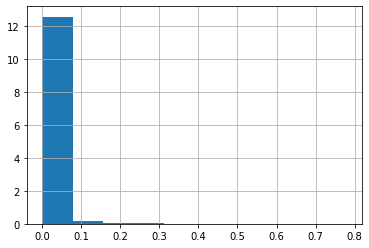

In [50]:
balanced_target = get_degree_stratification(all_samples, ratio = [0.1,0.9], return_item = 'df', on = 'target')
print(len(balanced_target))
(balanced_target['degree_fraction']).hist(density = True)

#print(len(get_degree_stratification(all_samples, ratio = [0.30, 0.70], return_item = 'df', on = 'target')['degree_fraction']))
#get_degree_stratification(all_samples, ratio = [0.30, 0.70], return_item = 'df', on = 'target')['degree_fraction'].hist()

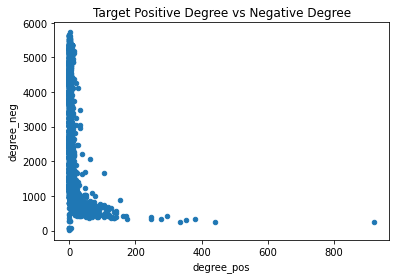

In [51]:
balanced_target.plot.scatter(x = 'degree_pos', y = 'degree_neg', title = 'Target Positive Degree vs Negative Degree')

7468


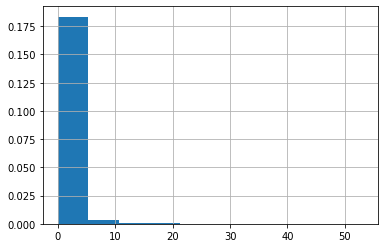

In [33]:
balanced_drug = get_degree_stratification(all_samples, ratio = [0.0001,0.8], return_item = 'df', on = 'drug')
print(len(balanced_drug))
(balanced_drug['degree_fraction']*100).hist(density = True)

#print(len(get_degree_stratification(all_samples, ratio = [0.30, 0.70], return_item = 'df', on = 'target')['degree_fraction']))
#get_degree_stratification(all_samples, ratio = [0.30, 0.70], return_item = 'df', on = 'target')['degree_fraction'].hist()

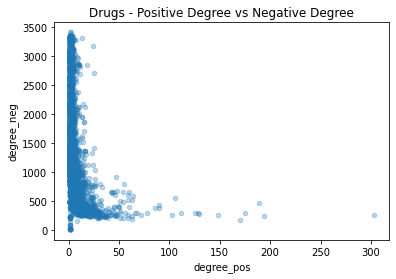

In [34]:
balanced_drug.plot.scatter(x = 'degree_pos', y = 'degree_neg', title = 'Drugs - Positive Degree vs Negative Degree', alpha = 0.3)

## Filter by Balanced

In [24]:
## Drugs are selected to have at most 20% imbalance
bal_drug_filtered_samples = all_samples[all_samples['InChiKey'].isin(balanced_drug.index)]

In [25]:
get_unique_counts(bal_drug_filtered_samples)

Distinct TARGETS in positive smaples:  4611
Distinct TARGETS in negative smaples:  4611
Distinct DRUGS in positive smaples:  7468
Distinct DRUGS in negative smaples:  7468


(4611, 4611, 7468, 7468)

In [26]:
## Targets are selected to have at most 20% imbalance
bal_target_filtered_samples = all_samples[all_samples['target_aa_code'].isin(balanced_target.index)]

In [27]:
get_unique_counts(bal_target_filtered_samples)

Distinct TARGETS in positive smaples:  4611
Distinct TARGETS in negative smaples:  4611
Distinct DRUGS in positive smaples:  7468
Distinct DRUGS in negative smaples:  7468


(4611, 4611, 7468, 7468)

In [28]:
## Drug AND Targets are selected to have at most 20% imbalance
bal_both_filtered_samples = all_samples[(all_samples['target_aa_code'].isin(balanced_target.index)) & 
                                       (all_samples['InChiKey'].isin(balanced_drug.index))]

In [29]:
bal_both_filtered_samples
get_unique_counts(bal_both_filtered_samples)

Distinct TARGETS in positive smaples:  4611
Distinct TARGETS in negative smaples:  4611
Distinct DRUGS in positive smaples:  7468
Distinct DRUGS in negative smaples:  7468


(4611, 4611, 7468, 7468)

In [117]:
## Drug OR Targets are selected to have at most 20% imbalance. in other words, pairs are selected such that either drugs or target has at most 20% imbalance
bal_either_filtered_samples = all_samples[(all_samples['target_aa_code'].isin(balanced_target.index)) | 
                                       (all_samples['InChiKey'].isin(balanced_drug.index))]

In [118]:
get_unique_counts(bal_either_filtered_samples)

Distinct TARGETS in positive smaples:  4409
Distinct TARGETS in negative smaples:  4860
Distinct DRUGS in positive smaples:  490007
Distinct DRUGS in negative smaples:  293625


(4409, 4860, 490007, 293625)

In [119]:

##This menthod only checks for postive samples that are in the negative sample
bal_simple_presence_check = all_samples[(all_samples['InChiKey'].isin(all_samples[all_samples['Y'] == 0]['InChiKey'].unique())) & \
                         (all_samples['target_aa_code'].isin(all_samples[all_samples['Y'] == 0]['target_aa_code'].unique()))]


get_unique_counts(bal_simple_presence_check)


Distinct TARGETS in positive smaples:  3375
Distinct TARGETS in negative smaples:  5826
Distinct DRUGS in positive smaples:  104996
Distinct DRUGS in negative smaples:  336895


(3375, 5826, 104996, 336895)

In [120]:
## Select a sample to use

selected_interactions = bal_either_filtered_samples

3703


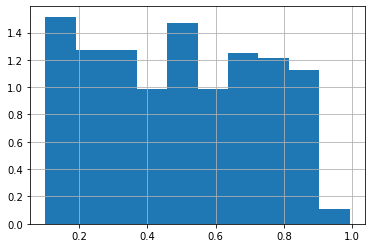

In [121]:
selected_target = get_degree_stratification(selected_interactions, ratio = [0.1,1], return_item = 'df', on = 'target')
print(len(selected_target))
(selected_target['degree_fraction']).hist(density = True)

#print(len(get_degree_stratification(all_samples, ratio = [0.30, 0.70], return_item = 'df', on = 'target')['degree_fraction']))
#get_degree_stratification(all_samples, ratio = [0.30, 0.70], return_item = 'df', on = 'target')['degree_fraction'].hist()

104604


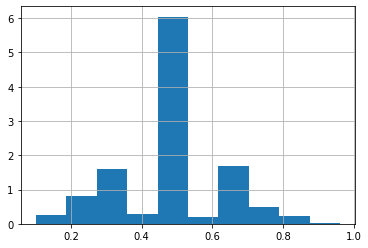

In [122]:
selected_drug = get_degree_stratification(selected_interactions, ratio = [0.1,1], return_item = 'df', on = 'drug')
print(len(selected_drug))
(selected_drug['degree_fraction']).hist(density = True)

#print(len(get_degree_stratification(all_samples, ratio = [0.30, 0.70], return_item = 'df', on = 'target')['degree_fraction']))
#get_degree_stratification(all_samples, ratio = [0.30, 0.70], return_item = 'df', on = 'target')['degree_fraction'].hist()

In [123]:
selected_interactions.to_csv(f'/data/sars-busters-consolidated/interactions/dataset_2_filtered.csv') ## was dataset_3_unfiltered

In [100]:
selected_interactions

,Target,Source,Type,Y,InChiKey,target_aa_code
0,6093,11246,Undirected,1,DEJXHCDDTLTVNB-FRVJLOGJSA-N,MEVQLGLGRVYPRPPSKTYRGAFQNLFQSVREVIQNPGPRHPEAAS...
2,5855,11533,Undirected,1,KFQYTPMOWPVWEJ-INIZCTEOSA-N,MDVLSPGQGNNTTSPPAPFETGGNTTGISDVTVSYQVITSLLLGTL...
5,1863,9813,Undirected,1,AVOLMBLBETYQHX-UHFFFAOYSA-N,MAFNDLLQQVGGVGRFQQIQVTLVVLPLLLMASHNTLQNFTAAIPT...
6,4119,9499,Undirected,1,OGHNVEJMJSYVRP-UHFFFAOYSA-N,MVFLSGNASDSSNCTQPPAPVNISKAILLGVILGGLILFGVLGNIL...
9,3348,9152,Undirected,1,QXWZQTURMXZVHJ-UHFFFAOYSA-N,MDLEGDRNGGAKKKNFFKLNNKSEKDKKEKKPTVSVFSMFRYSNWL...
...,...,...,...,...,...,...
506151,11167,9261,Undirected,0,BLIJXOOIHRSQRB-PXYINDEMSA-N,MNALVGCTTSFDPGWEVDAFGAVSNLCQPMEADLYGCADPCWWPAQ...
506153,5564,9381,Undirected,0,CHQOEHPMXSHGCL-UHFFFAOYSA-N,MERPLESYKKEAAHAAIAYVQDGMVVGLGTGSTARYAVLELARRLR...
506160,454,11202,Undirected,0,JIDRTCHFBHJIDG-UHFFFAOYSA-N,MATEGMILTNHDHQIRVGVLTVSDSCFRNLAEDRSGINLKDLVQDP...
506167,7001,12982,Undirected,0,RXWNCPJZOCPEPQ-NVWDDTSBSA-N,MSKGLPARQDMEKERETLQAWKERVGQELDRVVAFWMEHSHDQEHG...


## Chemicals: Add Fingerprints

In [5]:
chemicals = nodes[nodes['Type'] == 'Chemical']

In [77]:
with open('/data/covid-target-finder/Chemical_Details_BindingDB_DrugBank_NDM.pickle', 'rb') as f:
    
    chemical_map = pkl.load(f)

In [78]:
chemicals['Label'].map({i:v['SMILE'] for i,v in chemical_map.items()}).values

array(['CCN1C=C(C(O)=O)C(=O)C2=CC(F)=C(N=C12)N1CCNCC1',
       'FC(F)(F)C1=CC=C(CNC2=NC=C(CC3=CNC4=NC=C(Cl)C=C34)C=C2)C=N1',
       'CCCCCCCCCCCCOC(=O)C1=CC(=C(C(=C1)O)O)O', ...,
       '[H][C@@]1(N)CCCN(C1)C1=NC2=C(N1CC1=CC=CC=C1C#N)C(=O)N(C)C(=O)N2C',
       'CCOC(=O)C1=CN=C(N)N=C1O', 'OCCSSCCO'], dtype=object)

In [79]:
chemicals.loc[:,'SMILE'] = chemicals['Label'].map({i:v['SMILE'] for i,v in chemical_map.items()}).values
chemicals.loc[:,'Name'] = chemicals['Label'].map({i:v['chem_name'] for i,v in chemical_map.items()}).values



/miniconda/lib/python3.6/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/miniconda/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [80]:
def get_ordered_fingerprint_string_new(SMILE, radius = 2):
    try:
        bi = {}
        AllChem.GetMorganFingerprint(Chem.MolFromSmiles(SMILE), radius=radius, bitInfo=bi)
        fragments = []
        orders = []
        
        for fragment, presence in bi.items():
            for instance in presence:
                fragments.append(fragment)
                orders.append(instance[0])
        
        fragments = np.array(fragments)
        orders = np.array(orders)
        fingerprints = fragments[orders.argsort()]
        
        return ' '.join([str(i) for i in list(fingerprints)])
    
    except Exception as e:
        print(e)
        print(SMILE)
        return 

In [81]:
chemicals['fingerprint'] = chemicals['SMILE'].progress_apply(get_ordered_fingerprint_string_new)

Python argument types in
    rdkit.Chem.rdMolDescriptors.GetMorganFingerprint(NoneType)
did not match C++ signature:
    GetMorganFingerprint(RDKit::ROMol mol, int radius, boost::python::api::object invariants=[], boost::python::api::object fromAtoms=[], bool useChirality=False, bool useBondTypes=True, bool useFeatures=False, bool useCounts=True, boost::python::api::object bitInfo=None)
NC1=C(C2=C(N)N=C(N)N=C2C=C1)[Cl](=O)=O
Python argument types in
    rdkit.Chem.rdMolDescriptors.GetMorganFingerprint(NoneType)
did not match C++ signature:
    GetMorganFingerprint(RDKit::ROMol mol, int radius, boost::python::api::object invariants=[], boost::python::api::object fromAtoms=[], bool useChirality=False, bool useBondTypes=True, bool useFeatures=False, bool useCounts=True, boost::python::api::object bitInfo=None)
CCC1=C2C=C3N4C(=CC5=[N+]6C(=CC7=[N]8(C)C(=CC(N2[Cu-]468)=C1C)C(CC)=C7C)C(C)=C5CCC(O)=O)C(CCC(O)=O)=C3C
Python argument types in
    rdkit.Chem.rdMolDescriptors.GetMorganFingerprint(

/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [82]:
pd.merge(get_degree_stratification(all_samples, ratio = [0,1], return_item = 'df', on = 'target'), chemicals, left_index = True, right_on = 'Label')

,degree_pos,degree_neg,total_degree,degree_fraction,Label,Type,IsDrug,IsNDM,IsDrugTarget,IsNDMTarget,Type2,SMILE,Name,fingerprint
Id,,,,,,,,,,,,,,


In [102]:
chemicals.to_csv('/data/sars-busters/chemicals/chemicals_01.csv')

## Chemicals: Add Padding and PseudoOneHot

In [83]:
chemicals

,Label,Type,IsDrug,IsNDM,IsDrugTarget,IsNDMTarget,Type2,SMILE,Name,fingerprint
Id,,,,,,,,,,
1,IDYZIJYBMGIQMJ-UHFFFAOYSA-N,Chemical,True,False,False,False,Just DrugBank,CCN1C=C(C(O)=O)C(=O)C2=CC(F)=C(N=C12)N1CCNCC1,Enoxacin,3542456614 2246728737 2245384272 446551469 225...
2,JGWRKYUXBBNENE-UHFFFAOYSA-N,Chemical,True,False,False,False,Just DrugBank,FC(F)(F)C1=CC=C(CNC2=NC=C(CC3=CNC4=NC=C(Cl)C=C...,Pexidartinib,485463469 882399112 2245277810 1312131881 3313...
3,RPWFJAMTCNSJKK-UHFFFAOYSA-N,Chemical,False,True,False,False,Just NDM,CCCCCCCCCCCCOC(=O)C1=CC(=C(C(=C1)O)O)O,Dodecyl gallate,3542456614 2246728737 2245384272 1173125914 16...
4,HUJXISJLAPAFBO-IBGZPJMESA-N,Chemical,True,False,False,False,Just DrugBank,[H][C@@](C(=O)NC1=CC=C2C=CC=CC2=C1)(C1=CSC2=C1...,[(1S)-1-(5-CHLORO-1-BENZOTHIEN-3-YL)-2-(2-NAPH...,4290156734 2245273601 2161429032 4222851645 22...
5,HDWIHXWEUNVBIY-UHFFFAOYSA-N,Chemical,True,False,False,False,Just DrugBank,NS(=O)(=O)C1=CC2=C(NC(CC3=CC=CC=C3)NS2(=O)=O)C...,Bendroflumethiazide,3275683399 847957139 4285418163 3532053313 999...
...,...,...,...,...,...,...,...,...,...,...
13210,IQFWYNFDWRYSRA-OEQWSMLSSA-N,Chemical,True,False,False,False,Just DrugBank,N[C@@H](CCSC[C@H]1O[C@@H](O)[C@H](O)[C@@H]1O)C...,"5-(3-Amino-4,4-Dihyroxy-Butylsulfanylmethyl)-T...",2599973650 847957139 4274980665 3956283135 224...
13212,OHCQJHSOBUTRHG-HBQIERAFNA-N,Chemical,False,False,False,False,Chemical,CC(=O)O[C@H]1[C@@H](O)[C@H]2C(C)(C)CC[C@H](O)[...,"(3R,4aR,5S,6S,6aS,10S,10aR,10bS)-3-ethenyl-6,1...",2246728737 3545365497 2246699815 2664995851 12...
13213,XJNKUWDMCBZMTG-OAHLLOKOSA-N,Chemical,True,False,False,False,Just DrugBank,[H][C@@]1(N)CCCN(C1)C1=NC2=C(N1CC1=CC=CC=C1C#N...,"2-({8-[(3R)-3-AMINOPIPERIDIN-1-YL]-1,3-DIMETHY...",2976033787 3222961990 636990493 1323888424 847...


In [84]:
## Filter Chemicals whose fingerprints cannot be resolved
chemicals = chemicals[chemicals['fingerprint'].apply(lambda x: type(x)) == str]


In [85]:
chemicals['fingerprint_encoded'] = chemicals['fingerprint']\
                                                    .progress_apply(lambda x: x.replace(' ', ''))\
                                                    .progress_apply(lambda x: [int(i) for i in x])

/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [86]:
chemicals['fingerprint_encoded_len'] = chemicals['fingerprint_encoded']\
                                             .apply(lambda x: len(x))

#max_drug_fingerprint_encoded_len = max([max(all_samples['drug_fingerprint_encoded_len']), max(all_drugs['drug_fingerprint_encoded_len'])])
max_fingerprint_encoded_len = max(chemicals['fingerprint_encoded_len']) ## 14910

chemicals['fingerprint_encoded_mismatch'] = max_fingerprint_encoded_len - chemicals['fingerprint_encoded_len'] 



/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [87]:
chemicals['fingerprint_encoded_padded'] = chemicals[['fingerprint_encoded','fingerprint_encoded_mismatch']]\
                                         .progress_apply(lambda x: ['-1' for i in range(int(x['fingerprint_encoded_mismatch']/2))] +   
                                                        list(x['fingerprint_encoded']) +
                                                        ['-1' for i in range (int(x['fingerprint_encoded_mismatch']/2))]
                                                        , axis = 1)

chemicals['fingerprint_encoded_padded'] = chemicals['fingerprint_encoded_padded'].progress_apply(lambda x: x + ['-1'] if len(x) < max_fingerprint_encoded_len else x)


/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [88]:
chemicals[chemicals['fingerprint'].apply(lambda x: type(x)) != str]

,Label,Type,IsDrug,IsNDM,IsDrugTarget,IsNDMTarget,Type2,SMILE,Name,fingerprint,fingerprint_encoded,fingerprint_encoded_len,fingerprint_encoded_mismatch,fingerprint_encoded_padded
Id,,,,,,,,,,,,,,


In [89]:
chemicals = pd.merge(get_degree_stratification(all_samples, ratio = [0,1], return_item = 'df', on = 'drug'), chemicals, left_index = True, right_on = 'Label', how = 'right')

In [92]:
chemicals['fingerprint_random_padded'] = chemicals['fingerprint_encoded_padded'].apply(lambda x: random.choices([0,1], weights=None, cum_weights=None, k=14910))

In [93]:
chemicals.to_csv('/data/sars-busters/chemicals/chemicals_01.csv')

## Amino: Padding and Encode

In [12]:
amino = nodes[nodes['Type'] == 'Protein']

In [13]:
bits_5 = ['00000','00001', '00010', '00011',
          '00100','00101', '00110', '00111',
          '01000','01001', '01010', '01011',
          '01100','01101', '01110', '01111',
          '10000','10001', '10010', '10011',
          '10100','10101', '10110', '10111',
          '11000','11001', '11010', '11011',
          '11100','11101', '11110', '11111']

all_chars = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

all_char_onehot = {all_chars[i]:bits_5[i] for i in range(len(all_chars))}



#chemicals['target_aa_encoded'] = chemicals['target_aa_code'].str.upper().apply(lambda x: ''.join([all_char_onehot[i] for i in x]))

In [14]:
#Label Encoding
ENCODING_SCHEME = 'PsuedoOneHot'

if ENCODING_SCHEME == 'LabelEncoder':



    amino = amino[~ amino['Label'].isna()]
    amino['target_encoded'] = amino['Label']\
                                            .str.upper()\
                                            .progress_apply(list)\
                                            .progress_apply(label_encoder.transform)

elif ENCODING_SCHEME == 'PsuedoOneHot':


    ##OneHot Encoding

    amino = amino[~ amino['Label'].isna()]
    amino['target_encoded'] = amino['Label']\
                                            .str.upper()\
                                            .str.upper().progress_apply(lambda x: ''.join([all_char_onehot[i] for i in x]))

In [16]:
amino['target_encoded_len'] = amino['target_encoded']\
                                          .apply(lambda x: len(x))

max_target_encoded_len = 35480
#max_target_encoded_len = max(amino['target_encoded_len'])


amino['target_encoded_mismatch'] = max_target_encoded_len - amino['target_encoded_len']



In [17]:
amino['target_encoded_padded'] = amino[['target_encoded','target_encoded_mismatch']]\
                                         .progress_apply(lambda x: str(len(['-1' for i in range(int(x['target_encoded_mismatch']/2))])) + ' : ' +   
                                                        str(len(list(x['target_encoded']))) + ':' + 
                                                        str(len(['-1' for i in range(int(x['target_encoded_mismatch']/2))]))
                                                        , axis = 1)

In [18]:
amino['target_encoded_padded'] = amino[['target_encoded','target_encoded_mismatch']]\
                                         .progress_apply(lambda x: ['-1' for i in range(int(x['target_encoded_mismatch']/2))] +   
                                                        list(x['target_encoded']) +
                                                        ['-1' for i in range(int(x['target_encoded_mismatch']/2))]
                                                        , axis = 1)

amino['target_encoded_padded'] = amino['target_encoded_padded'].progress_apply(lambda x: x + ['-1'] if len(x) < max_target_encoded_len else x)

In [102]:
#amino = pd.merge(get_degree_stratification(all_samples, ratio = [0,1], return_item = 'df', on = 'target'), amino, left_index = True, right_on = 'Label')

In [20]:
amino['target_random_padded'] = amino['target_encoded_padded'].apply(lambda x: random.choices([0,1], weights=None, cum_weights=None, k=35480))

In [22]:
amino.to_csv('/data/sars-busters/amino/amino_01.csv')

In [ ]:
#chemicals['fingerprint_random_padded'] = chemicals['fingerprint_encoded_padded'].apply(lambda x: random.choices([0,1], weights=None, cum_weights=None, k=14910))
#amino['target_random_padded'] = amino['target_encoded_padded'].apply(lambda x: random.choices([0,1], weights=None, cum_weights=None, k=35480))




## Train Test Split

In [71]:
train_amino, test_amino = train_test_split(amino, test_size = 0.05)

In [72]:
train_chemicals, test_chemicals = train_test_split(chemicals, test_size = 0.05)

In [73]:
##Version 03 Unseen Target and Drug 

train_interactions = selected_interactions[(selected_interactions['InChiKey'].isin(list(train_chemicals['Label']))) \
                    & (selected_interactions['target_aa_code'].isin(list(train_amino['Label'])))]
test_interactions = selected_interactions[(selected_interactions['InChiKey'].isin(list(test_chemicals['Label']))) \
                    & (selected_interactions['target_aa_code'].isin(list(test_amino['Label'])))]

train_interactions['unseen'] = 'drugs+targets'
test_interactions['unseen'] = 'drugs+targets'

/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [74]:
##Version 04 Unseen Target

train_amino, test_amino = train_test_split(amino, test_size = 0.10)

train_interactions_temp = train_interactions[train_interactions['target_aa_code'].isin(list(train_amino['Label']))]
test_interactions_temp = train_interactions[train_interactions['target_aa_code'].isin(list(test_amino['Label']))]

train_interactions_temp['unseen'] = 'targets'
test_interactions_temp['unseen'] = 'targets'

/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [75]:
train_interactions_temp_1,  test_interactions_temp_1 = train_test_split(train_interactions_temp, test_size = 0.25)

In [76]:
train_interactions_temp_1['unseen'] = 'edges'
test_interactions_temp_1['unseen'] = 'edges'

/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [77]:
pd.concat([train_interactions,train_interactions_temp, train_interactions_temp_1])['unseen'].value_counts()

drugs+targets    69508
targets          62441
edges            46830
Name: unseen, dtype: int64

In [78]:
pd.concat([test_interactions,test_interactions_temp, test_interactions_temp_1])['unseen'].value_counts()

edges            15611
targets           7067
drugs+targets      165
Name: unseen, dtype: int64

In [79]:
len(set(train_interactions_temp_1['target_aa_code'].unique()).intersection(test_interactions['target_aa_code'].unique()))

0

In [80]:
train_interactions = pd.concat([train_interactions,train_interactions_temp, train_interactions_temp_1])
test_interactions  = pd.concat([test_interactions,test_interactions_temp, test_interactions_temp_1])

In [81]:
train_interactions.sample(frac=1).to_csv(f'/data/sars-busters/{OUTPUT_DIR}/train_interactions_{VERSION}.csv')
test_interactions.sample(frac=1).to_csv(f'/data/sars-busters/{OUTPUT_DIR}/test_interactions_{VERSION}.csv')

In [249]:
len(train_interactions)

175894

In [151]:
len(test_interactions)

18497

In [152]:
len(test_interactions)/(len(test_interactions) + len(train_interactions))

0.2433783766003079

In [153]:
train_interactions = pd.merge(get_degree_stratification(all_samples, 
                                                        ratio = [0,1],
                                                        return_item = 'df',
                                                        on = 'drug')[['degree_fraction', 'total_degree']].rename(columns = {'degree_fraction': 'drug_degree_fraction',
                                                                                                                   'total_degree': 'drug_total_degree'}), train_interactions,
                                                    how = 'right', left_index = True, right_on = 'InChiKey')

In [154]:
train_interactions = pd.merge(get_degree_stratification(all_samples,
                                                        ratio = [0,1],
                                                        return_item = 'df',
                                                        on = 'target')[['degree_fraction', 'total_degree']].rename(columns = {'degree_fraction': 'target_degree_fraction',
                                                                                                                   'total_degree': 'target_total_degree'}), train_interactions,
                                    how = 'right', left_index = True, right_on = 'target_aa_code')

In [167]:
pd.merge(get_degree_stratification(train_interactions, 
                                                        ratio = [0,1],
                                                        return_item = 'df',
                                                        on = 'drug')[['degree_fraction', 'total_degree']].rename(columns = {'degree_fraction': 'drug_degree_fraction',
                                                                                                                   'total_degree': 'drug_total_degree'}), train_interactions,
                                                    how = 'right', left_index = True, right_on = 'InChiKey')

,drug_degree_fraction_x,drug_total_degree_x,target_degree_fraction,target_total_degree,drug_degree_fraction_y,drug_total_degree_y,Target,Source,Type,Y,InChiKey,target_aa_code
4,0.285714,7.0,0.100000,10.0,0.222222,9.0,9288,2799,Undirected,1,VJYDOJXJUCJUHL-UHFFFAOYSA-N,MGPLPVCLPIMLLLLLPSLLLLLLLPGPGSGEASRILRVHRRGILE...
7,0.500000,4.0,0.959184,147.0,0.400000,5.0,9735,9332,Undirected,1,ANAMDWGJXBYJEB-OPWFCKQNSA-N,MTMTLHTKASGMALLHQIQGNELEPLNRPQLKIPLERPLGEVYLDS...
9,0.636364,11.0,0.990991,444.0,0.636364,11.0,3348,9152,Undirected,1,QXWZQTURMXZVHJ-UHFFFAOYSA-N,MDLEGDRNGGAKKKNFFKLNNKSEKDKKEKKPTVSVFSMFRYSNWL...
11,0.500000,16.0,0.994595,925.0,0.615385,26.0,2,5768,Undirected,1,JGWRKYUXBBNENE-UHFFFAOYSA-N,MALIPDLAMETWLLLAVSLVLLYLYGTHSHGLFKKLGIPGPTPLPF...
13,0.454545,11.0,0.428571,14.0,0.416667,12.0,3057,885,Undirected,1,IBAQFPQHRJAVAV-ULAWRXDQSA-N,MGVRHPPCSHRLLAVCALVSLATAALLGHILLHDFLLVPRELSGSS...
...,...,...,...,...,...,...,...,...,...,...,...,...
99167,NaN,NaN,0.333333,6.0,0.002217,451.0,12899,8704,Undirected,0,GFYFFUGNPVBDAK-ZHBCMPEGSA-L,MAQWNQLQQLDTRYLEQLHQLYSDSFPMELRQFLAPWIESQDWAYA...
99168,NaN,NaN,0.133333,15.0,0.002439,410.0,10292,8748,Undirected,0,DBPWWBMTZYJGGV-KKUMJFAQSA-N,MAAYKLVLIRHGESAWNLENRFSGWYDADLSPAGHEEAKRGGQALR...
99169,NaN,NaN,0.312500,16.0,0.003226,310.0,8201,7529,Undirected,0,ULQWGBCNOHBNDB-MRVPVSSYSA-N,MATENGAVELGIQNPSTDKAPKGPTGERPLAAGKDPGPPDPKKAPD...
99170,NaN,NaN,0.454545,11.0,0.002525,396.0,6913,36,Undirected,0,DEWDMTSMCKXBNP-SCSAIBSYSA-N,MSRLVVVSNRIAPPDEHAASAGGLAVGILGALKAAGGLWFGWSGET...


In [163]:
train_interactions.sample(frac=1).to_csv(f'/data/sars-busters/{OUTPUT_DIR}/train_interactions_{VERSION}.csv')
test_interactions.sample(frac=1).to_csv(f'/data/sars-busters/{OUTPUT_DIR}/test_interactions_{VERSION}.csv')

## Adjascency Matrix

In [41]:
adj_edges = train_interactions[(train_interactions['unseen'] == 'edges') & (train_interactions['Y'] == 1)]

In [42]:
adj_edges

,Target,Source,Type,Y,InChiKey,target_aa_code,unseen
20172,8587,5776,Undirected,1,LRJOMUJRLNCICJ-JZYPGELDSA-N,MGETEKRIETHRIRCLSKLKMFLLAITCAFVSKTLSGSYMNSMLTQ...,edges
28797,9889,10609,Undirected,1,PJVWKTKQMONHTI-UHFFFAOYSA-N,MALSWVLTVLSLLPLLEAQIPLCANLVPVPITNATLDQITGKWFYI...,edges
13408,5214,10431,Undirected,1,ZATGFXTWDKIEKC-UHFFFAOYSA-N,MGCVFCKKLEPVATAKEDAGLEGDFRSYGAADHYGPDPTKARPASS...,edges
27849,11137,10946,Undirected,1,HADYAKDSDIXWOF-UHFFFAOYSA-N,MLNLLLLALPVLASRAYAAPAPGQALQRVGIVGGQEAPRSKWPWQV...,edges
22298,13171,1704,Undirected,1,DBPPRLRVDVJOCL-FQRUVTKNSA-N,MPQPIHLKDHEKDARLVRRRVIVGAVAVVLLTLVLVARMYHLQVTQ...,edges
...,...,...,...,...,...,...,...
19514,10803,8202,Undirected,1,JOYRKODLDBILNP-UHFFFAOYSA-N,MGVPFFSSLRCMVDLGPCWAGGLTAEMKLLLALAGLLAILATPQPS...,edges
18767,4230,10638,Undirected,1,YTBGBMPLINFTBQ-OAHLLOKOSA-N,MSGADRSPNAGAAPDSAPGQAAVASAYQRFEPRAYLRNNYAPPRGD...,edges
4306,12420,10640,Undirected,1,VUCAHVBMSFIGAI-TWCWWGPMSA-M,MQGKKPGGSSGGGRSGELQGDEAQRNKKKKKKVSCFSNIKIFLVSE...,edges
29529,6858,5776,Undirected,1,FIQOFIRCTOWDOW-BJLQDIEVSA-N,MGETEKRIETHRIRCLSKLKMFLLAITCAFVSKTLSGSYMNSMLTQ...,edges


In [43]:
adj_edges.pivot(index = 'InChiKey', columns = 'target_aa_code', values = 'Y').fillna(0)

target_aa_code,AAACPRGQGRTLVSGLIYYITGSSKTNTEEKLMDFLLKEQKYNKLIRPATNSSQLVSIELQVSLAQLISVNEREQIMTTNVWLKQEWTDYRLAWDPSKYQGVKILRIPAKCIWLPDIVLYNNADGTYEVSLYTNAVVRFNGSIFWLPPAIYKSACKIEVKHFPFDQQNCTLKFRSWTYDHTEIDLVLKNAMASMDDFTPSGEWDIVALPGRRTINPLDPSYVDVTYDFIIKRKPLFYTINLIIPCVLITSLAILVFYLPSDCGEKMTLCISVLLALTVFLLLISKIVPPTSLDVPLIGKYLMFTMVLVTFSIVTSVCVLNVHHRSPSTHSMPPWVKLVFLKRLPTFLFMNRPENHPARQRPGPRRRNRAEATSPAELYKNSMYFVNPASAGKIQDTADGTGGQRDFRLRSSKKYQPEVQEAIDGVSFIAEHMKSDDSDQSVIEDWKYVAMVVDRLFLWIFVFVCVLGTVGLFLPPLFQNHSPPESP,AAMRYTEARLTPLAMEMLREIDEETVDFIPNYDGRVQEPTVLPSRFPNLLANGSGGIAVGMATNIPPHNLRELADAVFWALENHDADEEETLAAVMGRVKGPDFPTAGLIVGSQGTADAYKTGRGSIRMRGVVEVEEDSRGRTSLVITELPYQVNH,AAPYLKTKFICVTPTTCSNTIDLPMSPRTLDSLMQFGNGEGAEPSAGGQF,ADNLAEFHVQNQECDSCHTPDGELSNDSLTYENTQCVSCHGTLEEVAETTKHEHYNAHASHFPGEVACTSCHSAHEKSMVYCDSCHSFDFNMPYAKKWQRDEPTIAELAKDKSERQAALASAPHDTVDVVVVGSGGAGFSAAISATDSGAKVILIEKEPVIGGNAKLAAGGMNAAWTDQQKAKKITDSPELMFEDTMKGGQNINDPALVKVLSSHSKDSVDWMTAMGADLTDVGMMGGASVNRAHRPTGGAGVGAHVVQVLYDNAVKRNIDLRMNTRGIEVLKDDKGTVKGILVKGMYKGYYWVKADAVILATGGFAKNNERVAKLDPSLKGFISTNQPGAVGDGLDVAENAGGALKDMQYIQAHPTLSVKGGVMVTEAVRGNGAILVNREGKRFVNEITTRDKASAAILAQTGKSAYLIFDDSVRKSLSKIDKYIGLGVAPTADSLVKLGKMEGIDGKALTETVARYNSLVSSGKDTDFERPNLPRALNEGNYYAIEVTPGVHHTMGGVMIDTKAEVMNAKKQVIPGLYGAGEVTGGVHGANRLGGNAISDIITFGRLAGEEAAKYSKKN,ADSATPHLDAVEQTLRQVSPGLEGDVWERTSGNKLDGSAADPSDWLLQTPGCWGDDKCADRVGTKRLLAKMTENIGNATRTVDISTLAPFPNGAFQDAIVAGLKESAAKGNKLKVRILVGAAPVYHMNVIPSKYRDELTAKLGKAAENITLNVASMTTSKTAFSWNHSKILVVDGQSALTGGINSWKDDYLDTTHPVSDVDLALTGPAAGSAGRYLDTLWTWTCQNKSNIASVWFAASGNAGCMPTMHKDTNPKASPATGNVPVIAVGGLGVGIKDVDPKSTFRPDLPTASDTKCVVGLHDNTNADRDYDTVNPEESALRALVASAKGHIEISQQDLNATCPPLPRYDIRLYDALAAKMAAGVKVRIVVSDPANRGAVGSGGYSQIKSLSEISDTLRNRLANITGGQQAAKTAMCSNLQLATFRSSPNGKWADGHPYAQHHKLVSVDSSTFYIGSKNLYPSWLQDFGYIVESPEAAKQLDAKLLDPQWKYSQETATVDYARGICNA,ADTKEVLEAREAYFKSLGKSMKAMTGVAKSFDAEAAKAEAAALEKILATDVAPLFPAGTSSTDLPGQTEAKAAIWTNMADFGAKGKAMNDAGAEVIAAANAGDATAFGAALQKLGGTCKACHDDYREED,AESTLGAAAAQSGRYFGTAIASGKLGDSAYTTIASREFNMVTAENEMKIDATEPQRGQFNFSAGDRVYNWAVQNGKQVRGHTLAWHSQQPGWMQSLSGSTLRQAMIDHINGVMGHYKGKIAQWDVVNEAFSDDGSGGRRDSNLQRTGNDWIEVAFRTARAADPAAKLCYNDYNIENWTWAKTQGVYNMVRDFKQRGVPIDCVGFQSHFNSGSPYNSNFRTTLQNFAALGVDVAITELDIQGASSSTYAAVTNDCLAVSRCLGITVWGVRDTDSWRSGDTPLLFNGDGSKKAAYTAVLNALNGGSSTPPPSGGGQIKGVGSGRCLDVPNASTTDGTQVQLYDCHSATNQQWTYTDAGELRVYGDKCLDAAGTGNGTKVQIYSCWGGDNQKWRLNSDGSIVGVQSGLCLDAVGGGTANGTLIQLYSCSNGSNQRWTRT,AGVPFNTKTPYGPT,AHNIVLYTGAKMPILGLGTWKSPPGKVTEAVKVAIDLGYRHIDCAHVYQNENEVGLALQAKLQEQVVKREDLFIVSKLWCTYHDKDLVKGACQKTLSDLKLDYLDLYLIHWPTGFKPGKDFFPLDEDGNVIPSEKDFVDTWTAMEELVDEGLVKAIGVSNFNHLQVEKILNKPGLKYKPAVNQIECHPYLTQEKLIQYCNSKGIVVTAYSPLGSPDRPWAKPEDPSILEDPRIKAIADKYNKTTAQVLIRFPIQRNLIVIPKSVTPERIAENFQVFDFELDKEDMNTLLSYNRDWRACALVSCASHRDYPFHEEF,AIHPQTGELLALVSTPSYDVYPFMYGMSNEEYNKLTEDKKEPLLNKFQITTSPGSTQKILTAMIGLNNKTLDDKTSYKIDGKGWQKDKSWGGYNV,...,SGSWLRDVWDWICTVLTDFKTWLQSKLLPRIPGVPFLSCQRGYKGVWRGDGIMHTTCPCGAQITGHVKNGSMRIVGPKTCSNTWHGTFPINTYTTGPCTPSPAPNYSRALWRVAAEEYVEVTRVGDFHYVTGMTTDNVKCPCQVPAPEFFTEVDGVRLHRYAPACKPLLREEVTFMVGLNQYLVGSQLPCEPEPDVTVLTSMLTDPSHITAETAGRRLARGSPPSLASSSASQLSAPSLKATCTTRHDSPDADLIEANLLWRQEMGGNITRVESENKVVILDSFDPLQAEEDEREVSVPAEILRKSRKFPRAMPIWARPDYNPPLLESWKDPDYVPPVVHGCPLPPAKAPPIPPPRRKRTVVLTESTVSSALAELATKTFGSSGSSAVDSGTATAPPDQLPGDGDSGSDVESYSSMPPLEGEPGDPDLSDGSWSTMSEEASEDVVCC,SMSYTWTGALITPCAAEESKLPINALSNSLLRHHNMVYATTSRSASLRQKKVTFDRLQVLDDHYRDVLKEMKAKASTVKAKLLSVEEACKLTPPHSAKSKFGYGAKDVRNLSSKAVNHIRSVWKDLLEDTETPIDTTIMAKNEVFCVQPEKGGRKPARLIVFPDLGVRVCEKMALYDVVSTLPQAVMGSSYGFQYSPGQRVEFLVNTWKSKKCPMGFSYDTRCFDSTVTENDIRVEESIYQCCDLAPEARQAIRSLTERLYIGGPLTNSKGQNCGYRRCRASGVLTTSCGNTLTCYLKASAACRAAKLQDCTMLVCGDDLVVICESAGTQEDAASLRAFTEAMTRYSAPPGDPPQPEYDLELITSCSSNVSVAHDASGKRVYYLTRDPTTPLARAAWETARHTPVNSWLGNIIMYAPTLWARMILMTHFFSILLAQEQLEKALDCQIYGACYSIEPLDLPQIIQRLHGLSAFSLHSYSPGEINRVASCLRKLGVPPLRVWRHRARSVRARLLSQGGRAATCGKYLFNWAVRTKLKLTPIPAASQLDLSSWFVAGYSGGDIYHSLSRARPRWFMWCLLLLSVGVGIYLLPNR,SNLPPRIMAAGGLQMIGSMSKDMYQIMDEIKEGIQYVFQTRNPLTLVISGSGHCALEAALVNVLEPGDSFLVGANGIWGQRAVDIGERIGARVHPMTKDPGGHYTLQEVEEGLAQHKPVLLFLTHGESSTGVLQPLDGFGELCHRYKCLLLVDSVASLGGTPLYMDRQGIDIL

In [139]:
adj_edges.to_csv(f'/data/sars-busters/{OUTPUT_DIR}/adj_matrix_train_{VERSION}.csv')

In [140]:
f'/data/sars-busters/{OUTPUT_DIR}/adj_matrix_train_{VERSION}.csv'

'/data/sars-busters/interactions/adj_matrix_train_07.csv'

In [232]:
adj_edges = selected_interactions
adj_edges['fill'] = np.nan

/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [190]:
adj_edges = adj_edges.pivot(index = 'InChiKey', columns = 'target_aa_code', values = 'fill')

In [193]:
adj_edges.shape

(7229, 4209)

In [233]:
adj_edges_pos = adj_edges.pivot(index = 'InChiKey', columns = 'target_aa_code', values = 'fill')
adj_edges_neg = adj_edges.pivot(index = 'InChiKey', columns = 'target_aa_code', values = 'fill')

In [234]:
for i,a in tqdm(selected_interactions[(selected_interactions['Y'] == 1)][['InChiKey', 'target_aa_code']].values):
    
    adj_edges_pos.loc[i,a] = 1

In [235]:
for i,a in tqdm(selected_interactions[(selected_interactions['Y'] == 0)][['InChiKey', 'target_aa_code']].values):
    
    adj_edges_neg.loc[i,a] = 1

In [236]:
adj_edges_pos = adj_edges_pos.fillna(0)

adj_edges_neg = adj_edges_neg.fillna(0)

In [237]:
adj_edges_pos.shape

(7229, 4209)

In [238]:
adj_edges_neg.shape

(7229, 4209)

In [239]:
selected_interactions['Y'].value_counts()

0    54428
1    21573
Name: Y, dtype: int64

In [240]:
np.array(adj_edges_pos).sum()

21573.0

In [241]:
np.array(adj_edges_neg).sum()

54428.0

In [ ]:
adj_edges_neg.to_csv(f'/data/sars-busters/{OUTPUT_DIR}/adj_neg_matrix_train_{VERSION}.csv')
adj_edges_pos.to_csv(f'/data/sars-busters/{OUTPUT_DIR}/adj_pos_matrix_train_{VERSION}.csv')

## A^3

In [71]:
adj_edges = train_interactions[train_interactions['unseen'] == 'edges'].pivot(index = 'InChiKey', columns = 'target_aa_code', values = 'Y').fillna(0)


In [72]:
adj_edges

target_aa_code,AAACPRGQGRTLVSGLIYYITGSSKTNTEEKLMDFLLKEQKYNKLIRPATNSSQLVSIELQVSLAQLISVNEREQIMTTNVWLKQEWTDYRLAWDPSKYQGVKILRIPAKCIWLPDIVLYNNADGTYEVSLYTNAVVRFNGSIFWLPPAIYKSACKIEVKHFPFDQQNCTLKFRSWTYDHTEIDLVLKNAMASMDDFTPSGEWDIVALPGRRTINPLDPSYVDVTYDFIIKRKPLFYTINLIIPCVLITSLAILVFYLPSDCGEKMTLCISVLLALTVFLLLISKIVPPTSLDVPLIGKYLMFTMVLVTFSIVTSVCVLNVHHRSPSTHSMPPWVKLVFLKRLPTFLFMNRPENHPARQRPGPRRRNRAEATSPAELYKNSMYFVNPASAGKIQDTADGTGGQRDFRLRSSKKYQPEVQEAIDGVSFIAEHMKSDDSDQSVIEDWKYVAMVVDRLFLWIFVFVCVLGTVGLFLPPLFQNHSPPESP,AAMRYTEARLTPLAMEMLREIDEETVDFIPNYDGRVQEPTVLPSRFPNLLANGSGGIAVGMATNIPPHNLRELADAVFWALENHDADEEETLAAVMGRVKGPDFPTAGLIVGSQGTADAYKTGRGSIRMRGVVEVEEDSRGRTSLVITELPYQVNH,AAPYLKTKFICVTPTTCSNTIDLPMSPRTLDSLMQFGNGEGAEPSAGGQF,ADNLAEFHVQNQECDSCHTPDGELSNDSLTYENTQCVSCHGTLEEVAETTKHEHYNAHASHFPGEVACTSCHSAHEKSMVYCDSCHSFDFNMPYAKKWQRDEPTIAELAKDKSERQAALASAPHDTVDVVVVGSGGAGFSAAISATDSGAKVILIEKEPVIGGNAKLAAGGMNAAWTDQQKAKKITDSPELMFEDTMKGGQNINDPALVKVLSSHSKDSVDWMTAMGADLTDVGMMGGASVNRAHRPTGGAGVGAHVVQVLYDNAVKRNIDLRMNTRGIEVLKDDKGTVKGILVKGMYKGYYWVKADAVILATGGFAKNNERVAKLDPSLKGFISTNQPGAVGDGLDVAENAGGALKDMQYIQAHPTLSVKGGVMVTEAVRGNGAILVNREGKRFVNEITTRDKASAAILAQTGKSAYLIFDDSVRKSLSKIDKYIGLGVAPTADSLVKLGKMEGIDGKALTETVARYNSLVSSGKDTDFERPNLPRALNEGNYYAIEVTPGVHHTMGGVMIDTKAEVMNAKKQVIPGLYGAGEVTGGVHGANRLGGNAISDIITFGRLAGEEAAKYSKKN,ADSATPHLDAVEQTLRQVSPGLEGDVWERTSGNKLDGSAADPSDWLLQTPGCWGDDKCADRVGTKRLLAKMTENIGNATRTVDISTLAPFPNGAFQDAIVAGLKESAAKGNKLKVRILVGAAPVYHMNVIPSKYRDELTAKLGKAAENITLNVASMTTSKTAFSWNHSKILVVDGQSALTGGINSWKDDYLDTTHPVSDVDLALTGPAAGSAGRYLDTLWTWTCQNKSNIASVWFAASGNAGCMPTMHKDTNPKASPATGNVPVIAVGGLGVGIKDVDPKSTFRPDLPTASDTKCVVGLHDNTNADRDYDTVNPEESALRALVASAKGHIEISQQDLNATCPPLPRYDIRLYDALAAKMAAGVKVRIVVSDPANRGAVGSGGYSQIKSLSEISDTLRNRLANITGGQQAAKTAMCSNLQLATFRSSPNGKWADGHPYAQHHKLVSVDSSTFYIGSKNLYPSWLQDFGYIVESPEAAKQLDAKLLDPQWKYSQETATVDYARGICNA,ADTKEVLEAREAYFKSLGKSMKAMTGVAKSFDAEAAKAEAAALEKILATDVAPLFPAGTSSTDLPGQTEAKAAIWTNMADFGAKGKAMNDAGAEVIAAANAGDATAFGAALQKLGGTCKACHDDYREED,AESTLGAAAAQSGRYFGTAIASGKLGDSAYTTIASREFNMVTAENEMKIDATEPQRGQFNFSAGDRVYNWAVQNGKQVRGHTLAWHSQQPGWMQSLSGSTLRQAMIDHINGVMGHYKGKIAQWDVVNEAFSDDGSGGRRDSNLQRTGNDWIEVAFRTARAADPAAKLCYNDYNIENWTWAKTQGVYNMVRDFKQRGVPIDCVGFQSHFNSGSPYNSNFRTTLQNFAALGVDVAITELDIQGASSSTYAAVTNDCLAVSRCLGITVWGVRDTDSWRSGDTPLLFNGDGSKKAAYTAVLNALNGGSSTPPPSGGGQIKGVGSGRCLDVPNASTTDGTQVQLYDCHSATNQQWTYTDAGELRVYGDKCLDAAGTGNGTKVQIYSCWGGDNQKWRLNSDGSIVGVQSGLCLDAVGGGTANGTLIQLYSCSNGSNQRWTRT,AEVLTSEQAEELHKHVIDGTRVFLVIAAIAHFLAFTLTPWLH,AGVPFNTKTPYGPT,AHNIVLYTGAKMPILGLGTWKSPPGKVTEAVKVAIDLGYRHIDCAHVYQNENEVGLALQAKLQEQVVKREDLFIVSKLWCTYHDKDLVKGACQKTLSDLKLDYLDLYLIHWPTGFKPGKDFFPLDEDGNVIPSEKDFVDTWTAMEELVDEGLVKAIGVSNFNHLQVEKILNKPGLKYKPAVNQIECHPYLTQEKLIQYCNSKGIVVTAYSPLGSPDRPWAKPEDPSILEDPRIKAIADKYNKTTAQVLIRFPIQRNLIVIPKSVTPERIAENFQVFDFELDKEDMNTLLSYNRDWRACALVSCASHRDYPFHEEF,...,SMSYTWTGALITPCAAEESKLPINALSNSLLRHHNMVYATTSRSASLRQKKVTFDRLQVLDDHYRDVLKEMKAKASTVKAKLLSVEEACKLTPPHSAKSKFGYGAKDVRNLSSKAVNHIRSVWKDLLEDTETPIDTTIMAKNEVFCVQPEKGGRKPARLIVFPDLGVRVCEKMALYDVVSTLPQAVMGSSYGFQYSPGQRVEFLVNTWKSKKCPMGFSYDTRCFDSTVTENDIRVEESIYQCCDLAPEARQAIRSLTERLYIGGPLTNSKGQNCGYRRCRASGVLTTSCGNTLTCYLKASAACRAAKLQDCTMLVCGDDLVVICESAGTQEDAASLRAFTEAMTRYSAPPGDPPQPEYDLELITSCSSNVSVAHDASGKRVYYLTRDPTTPLARAAWETARHTPVNSWLGNIIMYAPTLWARMILMTHFFSILLAQEQLEKALDCQIYGACYSIEPLDLPQIIQRLHGLSAFSLHSYSPGEINRVASCLRKLGVPPLRVWRHRARSVRARLLSQGGRAATCGKYLFNWAVRTKLKLTPIPAASQLDLSSWFVAGYSGGDIYHSLSRARPRWFMWCLLLLSVGVGIYLLPNR,SNLPPRIMAAGGLQMIGSMSKDMYQIMDEIKEGIQYVFQTRNPLTLVISGSGHCALEAALVNVLEPGDSFLVGANGIWGQRAVDIGERIGARVHPMTKDPGGHYTLQEVEEGLAQHKPVLLFLTHGESSTGVLQPLDGFGELCHRYKCLLLVDSVASLGGTPLYMDRQGIDILYSGSQKALNAPPGTSLIFFSDKAKKKMYSRKTKPFSFYLDIKWLANFWGCDDQPRMYHHTIPVISLYSLRESLALIAEQGLENSWRQHREAAAYLHGRLQALGLQLFVKDPALRLPTVTTVAVPAGYDWRDIVSYVIDHFDIEIMGGLGPSTGKVLRIGLLGCNATRENVDRVTEALRAALQHCKANL,SNRSLNATATQGAWDPGTLQALKIALVVLLSIITLATVLSNAFVLTTIFLTRKLHTPANCLIGSLAMTDLLVSILVMPISIAYTTTHTWSFGQLLCDIWLSSDITCCTASILHLCVIAL,TAWTFLKAMQKCSKKREARGSREAPETNFPDTTEESAQQICCTRDSSDSKSVPRSERNKKGIQCQGEGSSRGSQPGQFVGVTYNLEKRPTTIVLINDTPLNVLLDTGADTSVLTTAHYNRLKYRGRKYQGTGIIGVGGNVETFSTPVTIKKKGRHIKTRMLVADIPVTILGRDILQDLGAKLVLAQLSKEIK

In [257]:
inchikey_map = list(adj_edges.index)
aa_seq_map = list(adj_edges.columns)

In [ ]:
adj_edges = np.array(adj_edges)**3

## Test

In [10]:
amino = pd.read_csv('/data/sars-busters/amino/amino_01.csv')

In [23]:
amino[amino['Label'] == 'MGARASVLSGGKLDAWEKIRLRPGGKKKYRLKHLVWASRELERFALNPGLLETSDGCKQIIGQLQPAIRTGSEELRSLFNTVATLYCVHERIEVKDTKEALEKMEEEQNKSKNKKAQQAAADAGNNSQVSQNYPIVQNLQGQMVHQAISPRTLNAWVKVIEEKAFSPEVIPMFSALSEGATPQDLNTMLNTVGGHQAAMQMLKETINEEAAEWDRLHPVHAGPIAPGQMREPRGSDIAGTTSTLQEQIAWMTSNPPIPVGEIYKRWIILGLNKIVRMYSPVSILDIRQGPKEPFRDYVDRFYKTLRAEQASQEVKGWMTETLLVQNANPDCKTILKALGPQATLEEMMTACQGVGGPSHKARVLAEAMSQATNSAAAVMMQRGNFKGPRKTIKCFNCGKEGHIAKNCRAPRRKGCWKCGKEGHQLKDCTERQANFLREDLAFPQGKAGELSSEQTRANSPTSRELRVWGRDNPLSETGAERQGTVSFNCPQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMNLPGKWKPKMIGGIGGFIKVRQYDQILIEICGHKAIGTVLVGPTPVNIIGRNLLTQIGCTLNFPISPIETVPVKLKPGMDGPKVKQWPLTEEKIKALTEICTEMEKEGKISRVGPENPYNTPIFAIKKKDSTKWRKLVDFRELNKRTQDFWEVQLGIPHPAGLKKKKSVTVLDVGDAYFSVPLDKDFRKYTAFTIPSINNETPGIRYQYNVLPQGWKGSPAIFQSSMTKILEPFRKQNPEIVIYQYMDDLYVGSDLEIGQHRTKIEELREHLLRWGFTTPDKKHQKEPPFLWMGYELHPDKWTVQSIKLPEKESWTVNDIQKLVGKLNWASQIYPGIKVRQLCKLLRGTKALTEVIPLTEEAELELAENREILKEPVHGVYYDPSKDLIAEIQKQGHGQWTYQIYQEPFKNLKTGKYARMRGAHTNDVKQLAEVVQKISTESIVIWGKTPKFRLPIQKETWETWWVEYWQATWIPEWEFVNTPPLVKLWYQLEKEPIIGAETFYVDGAANRETKLGKAGYVTDRGRQKVVPFTDTTNQKTELQAINLALQDSGLEVNIVTDSQYALGIIQAQPDKSESELVSQIIEQLIKKEKVYLAWVPAHKGIGGNEQVDKLVSQGIRKVLFLDGIDKAQEEHEKYHNNWRAMASDFNLPPVVAKEIVASCDKCQLKGEAMHGQVDCSPGIWQLDCTHLEGKVILVAVHVASGYIEAEVIPAETGQETAYFILKLAGRWPVKIVHTDNGSNFTSAAVKAACWWAGIKQEFGIPYNPQSQGVVESMNKELKKIIGQVRDQAEHLKTAVQMAVFIHNFKRKGGIGGYSAGERIIDIIATDIQTKELQKQITKIQNFRVYYRDSRDPIWKGPAKLLWKGEGAVVIQDNSDIKVVPRRKVKIIRDYGKQMAGDDCVASRQDED']



,Label,Type,IsDrug,IsNDM,IsDrugTarget,IsNDMTarget,Type2,target_encoded,target_encoded_len,target_encoded_mismatch,target_encoded_padded,target_random_padded
Id,,,,,,,,,,,,
8067,MGARASVLSGGKLDAWEKIRLRPGGKKKYRLKHLVWASRELERFAL...,Protein,False,False,True,False,Protein,0110000110000001000100000100101010101011100100...,7180,28300,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, ..."


In [5]:
import os
os.getcwd()

'/home/sars-busters-consolidated/data_preperation'